In [184]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
df = pd.read_parquet("./datapred/data.parquet")

In [239]:
# Last steps of cleaning
df = df.dropna().reset_index(drop = True).drop(["NEIGHBORHOOD", "BUILDING_CLASS_CATEGORY",
                                                "BLOCK", "LOT", "ADDRESS", "APARTMENT_NUMBER",
                                                "BUILDING_CLASS_AT_TIME_OF_SALE", "SALE_DATE",
                                                "neighbourhood"],
                                               axis = 1)

df = pd.concat([pd.get_dummies(df["BOROUGH"], drop_first = True,
                               prefix = "BOROUGH"),
                df.drop("BOROUGH", axis = 1)], axis = 1)

df = pd.concat([df.iloc[:, :4],
                pd.get_dummies(df["TAX_CLASS_AT_PRESENT"], drop_first = True,
                               prefix = "TAX_CLASS_AT_PRESENT"),
                df.iloc[:, 5:]], axis = 1)

df = pd.concat([df.iloc[:, :12],
                pd.get_dummies(df["ZIP_CODE"], drop_first = True,
                               prefix = "ZIP_CODE"),
                df.iloc[:, 13:]], axis = 1)

df["LAND_SQUARE_FEET"] = df["LAND_SQUARE_FEET"].astype(int)
df["GROSS_SQUARE_FEET"] = df["GROSS_SQUARE_FEET"].astype(int)

df = pd.concat([df.iloc[:, :197],
                pd.get_dummies(df["TAX_CLASS_AT_TIME_OF_SALE"], drop_first = True,
                               prefix = "TAX_CLASS_AT_TIME_OF_SALE"),
                df.iloc[:, 198:]], axis = 1)

df = pd.concat([df.iloc[:, :201],
                pd.get_dummies(df["SALE_MONTH"], drop_first = True,
                               prefix = "SALE_MONTH"),
                df.iloc[:, 202:]], axis = 1)

df = pd.concat([df.iloc[:, :218],
                pd.get_dummies(df["room_type"], drop_first = True,
                               prefix = "room_type"),
                df.iloc[:, 219:]], axis = 1)

df.columns = [c.upper().replace(" ", "_") for c in df.columns]


df["SALE_PRICE"] = np.log(df["SALE_PRICE"])

In [315]:
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# RMK: sale price expressed in M USD

In [291]:
# TRAIN-TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(df.drop("SALE_PRICE", axis = 1),
                                                    df["SALE_PRICE"], random_state = 42,
                                                    shuffle = True, train_size = .7)

xscaler = StandardScaler()
xscaler.fit(X_train)

X_train = xscaler.transform(X_train)
X_test = xscaler.transform(X_test)

In [298]:
# LINEAR REGRESSION
lr_lasso = LassoCV(alphas = np.linspace(0.01, 2, 50),
                   cv = 5, n_jobs = -1, random_state = 42)
lr_lasso.fit(X_train, y_train)

print(f"Best alpha: {lr_lasso.alpha_}")

Best alpha: 0.01


In [312]:
print("MSE: {:.4f}".format(mean_squared_error(y_test, lr_lasso.predict(X_test))))
print("MAE: {:.4f}".format(mean_absolute_error(y_test, lr_lasso.predict(X_test))))

# With exponentiated values multiplied by 1e6
print("MSE: {:.2f} USD".format(mean_squared_error(np.exp(y_test)*1e6,
                                                  np.exp(lr_lasso.predict(X_test))*1e6)))
print("MAE: {:.2f} USD".format(mean_absolute_error(np.exp(y_test)*1e6,
                                                   np.exp(lr_lasso.predict(X_test))*1e6)))

print("MAPE: {:.2f} %".format(mean_absolute_percentage_error(np.exp(y_test)*1e6,
                                                             np.exp(lr_lasso.predict(X_test))*1e6)))

MSE: 0.9815
MAE: 0.7959
MSE: 1708771804176744448.00 USD
MAE: 16880787.30 USD
MAPE: 17.78 %


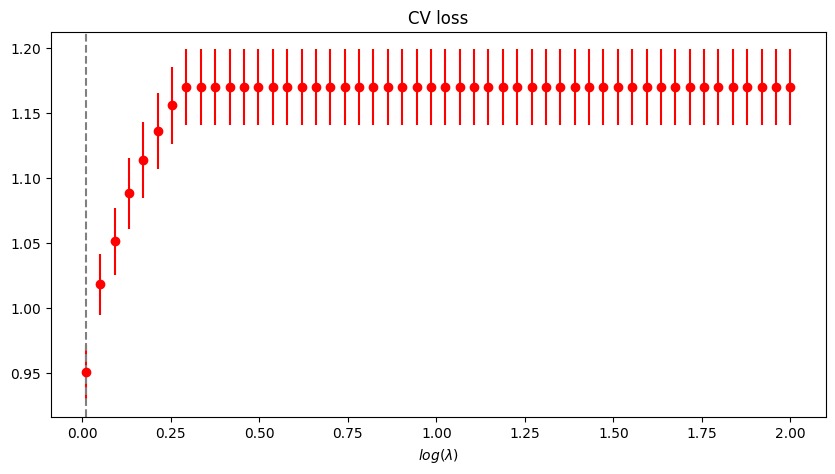

In [300]:
plt.figure(figsize = (10, 5))
plt.errorbar(lr_lasso.alphas_, lr_lasso.mse_path_.mean(axis = 1),
             yerr = lr_lasso.mse_path_.std(axis = 1), fmt = "o", color = "red")
plt.axvline(lr_lasso.alpha_, ls = "--", color = "grey")
plt.title("CV loss")
plt.xlabel("$log(\lambda)$")
plt.show()

Tree Train Accuracy: 0.0294



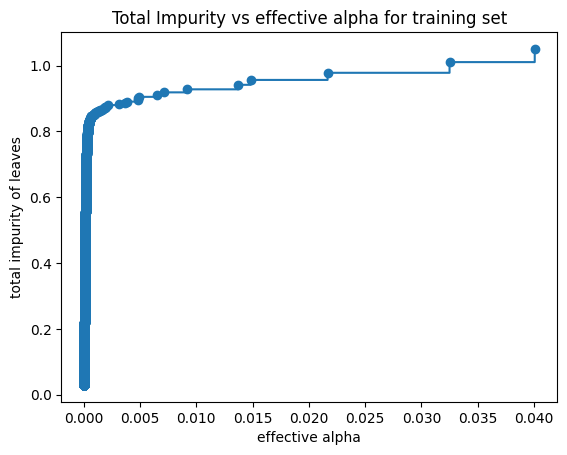

Fitting 3 folds for each of 5 candidates, totalling 15 fits
MSE: 1.0665
MAE: 0.7677
MSE: 6393162719630.29 USD
MAE: 1416053.33 USD
MAPE: 1.20 %
[CV 3/3; 2/5] START ccp_alpha=6.089113057749309e-05.............................
[CV 3/3; 2/5] END ccp_alpha=6.089113057749309e-05;, score=(train=0.867, test=-0.261) total time=  10.4s
[CV 2/3; 4/5] START ccp_alpha=0.00012108736080924601............................
[CV 2/3; 4/5] END ccp_alpha=0.00012108736080924601;, score=(train=0.748, test=-0.143) total time=   9.3s
[CV 1/3; 2/5] START ccp_alpha=6.089113057749309e-05.............................
[CV 1/3; 2/5] END ccp_alpha=6.089113057749309e-05;, score=(train=0.870, test=-0.317) total time=  10.3s
[CV 1/3; 4/5] START ccp_alpha=0.00012108736080924601............................
[CV 1/3; 4/5] END ccp_alpha=0.00012108736080924601;, score=(train=0.754, test=-0.187) total time=   9.3s
[CV 2/3; 2/5] START ccp_alpha=6.089113057749309e-05.............................
[CV 2/3; 2/5] END ccp_alpha=6.0891

In [317]:
# DECISION TREE
tree = DecisionTreeRegressor(random_state = 101, criterion = "squared_error")
tree.fit(X_train, y_train)
print("Tree Train MSE: {:.4f}\n".format((mean_squared_error(y_train, tree.predict(X_train)))))

# Compute impurities to look for an adequate pruning term
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the impurity level given ccp_alpha
plt.plot(ccp_alphas[:-1], impurities[:-1],
         marker = "o", drawstyle = "steps-post")
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set")
plt.show()

# Tree Pruning (we are overfitting - Accuracy: 100% in training)
tree_params = {"ccp_alpha":[ccp_alphas[impurities < impty].max()
                            for impty in np.linspace(0.1, np.round(impurities.max()/2, 3),
                                                     num = 5)]}

tree_grid = GridSearchCV(DecisionTreeRegressor(random_state = 101, criterion = "squared_error"),
                         tree_params, cv = 3, n_jobs = 6, verbose = 10,
                         return_train_score = True)
tree_grid.fit(X_train, y_train)

# Show the results
print("MSE: {:.4f}".format(mean_squared_error(y_test, tree_grid.best_estimator_.predict(X_test))))
print("MAE: {:.4f}".format(mean_absolute_error(y_test, tree_grid.best_estimator_.predict(X_test))))

# With exponentiated values multiplied by 1e6
print("MSE: {:.2f} USD"\
      .format(mean_squared_error(np.exp(y_test)*1e6,
                                 np.exp(tree_grid.best_estimator_.predict(X_test))*1e6)))
print("MAE: {:.2f} USD"\
      .format(mean_absolute_error(np.exp(y_test)*1e6,
                                  np.exp(tree_grid.best_estimator_.predict(X_test))*1e6)))

print("MAPE: {:.2f} %"\
      .format(mean_absolute_percentage_error(np.exp(y_test)*1e6,
                                             np.exp(tree_grid.best_estimator_.predict(X_test))*1e6)))

---
---
---